In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
import pyqg_subgrid_experiments as pse
from pyqg_generative.tools.operators import coord
from pyqg_generative.tools.computational_tools import PDF_histogram
from time import time
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pp2681/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [29]:
ds_test = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/[0-1].nc', combine='nested', concat_dim='run')
ds_train = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/[1-2].nc', combine='nested', concat_dim='run')

# OLS Model

In [3]:
model = OLSModel()

In [4]:
model.fit(ds_train, ds_test, num_epochs=1)
model.fit(ds_train, ds_test, num_epochs=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.52/0.00] Loss: [1.307, 1.007]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.46/0.00] Loss: [1.303, 1.013]


In [150]:
model.predict(ds_test)

<xarray.Dataset>
Dimensions:                   (run: 2, time: 86, lev: 2, y: 64, x: 64)
Dimensions without coordinates: run, time, lev, y, x
Data variables:
    q_forcing_advection       (run, time, lev, y, x) float32 -6.708e-13 ... -...
    q_forcing_advection_mean  (run, time, lev, y, x) float32 -6.708e-13 ... -...
    q_forcing_advection_var   (run, time, lev, y, x) float32 -0.0 -0.0 ... -0.0

In [152]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='AR1', nsteps=1)
%time m.run()

CPU times: user 379 ms, sys: 711 µs, total: 380 ms
Wall time: 381 ms


# MeanVar model

In [153]:
model = MeanVarModel()

In [154]:
model.fit(ds_train, ds_test, num_epochs=1)
model.fit(ds_train, ds_test, num_epochs=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.47/0.00] Loss: [1.407, 1.007]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [8.729, 8.487]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [1.403, 1.026]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [8.812, 8.575]


In [155]:
model.predict(ds_test)

<xarray.Dataset>
Dimensions:                   (run: 2, time: 86, lev: 2, y: 64, x: 64)
Dimensions without coordinates: run, time, lev, y, x
Data variables:
    q_forcing_advection       (run, time, lev, y, x) float64 5.833e-12 ... -2...
    q_forcing_advection_mean  (run, time, lev, y, x) float32 7.516e-14 ... 2....
    q_forcing_advection_var   (run, time, lev, y, x) float32 3.419e-23 ... 8....

In [156]:
offline = model.test_offline(ds_test)

In [157]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='constant', nsteps=1)
%time m.run()

CPU times: user 728 ms, sys: 3.42 ms, total: 732 ms
Wall time: 734 ms


# CGAN Model

In [28]:
model = CGANRegression()

In [30]:
model.fit(ds_train, ds_test, num_epochs=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [3.27/0.00] D_loss: 0.01 G_loss: 0.04 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
Optimal epoch is 1
checkpoints/G_1.pt  is loaded


In [31]:
offline = model.test_offline(ds_test)

In [32]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='constant', nsteps=1)
%time m.run()

CPU times: user 482 ms, sys: 2 ms, total: 484 ms
Wall time: 500 ms


# Do models converge somewhere after adaptation?

In [3]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', combine='nested', concat_dim='run')
ds_test = ds.isel(run=slice(0,25))
ds_train = ds.isel(run=slice(-250,None))

In [123]:
model = OLSModel()
model.fit(ds_train, ds_test, num_epochs=10)
ols = model.test_offline(ds_test)
ols[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.40/435.60] Loss: [0.346, 0.205]
[2/10] [48.36/387.04] Loss: [0.190, 0.176]
[3/10] [48.42/338.75] Loss: [0.172, 0.189]
[4/10] [48.44/290.43] Loss: [0.160, 0.153]
[5/10] [48.45/242.08] Loss: [0.151, 0.146]
[6/10] [48.46/193.69] Loss: [0.144, 0.143]
[7/10] [48.46/145.29] Loss: [0.143, 0.142]
[8/10] [48.45/96.86] Loss: [0.141, 0.142]
[9/10] [48.47/48.44] Loss: [0.141, 0.141]
[10/10] [48.46/0.00] Loss: [0.141, 0.142]


Frozen({'L2_mean': <xarray.Variable ()>
array(0.37001002, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.21740732, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(1., dtype=float32)})

In [125]:
model = MeanVarModel()
model.fit(ds_train, ds_test, num_epochs=10)
meanvar = model.test_offline(ds_test)
meanvar[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.41/435.70] Loss: [0.375, 0.203]
[2/10] [48.48/387.55] Loss: [0.189, 0.173]
[3/10] [48.48/339.19] Loss: [0.169, 0.160]
[4/10] [48.48/290.77] Loss: [0.158, 0.152]
[5/10] [48.47/242.31] Loss: [0.151, 0.152]
[6/10] [48.47/193.85] Loss: [0.143, 0.141]
[7/10] [48.48/145.40] Loss: [0.141, 0.140]
[8/10] [48.47/96.93] Loss: [0.140, 0.140]
[9/10] [48.46/48.47] Loss: [0.140, 0.140]
[10/10] [48.47/0.00] Loss: [0.140, 0.140]
Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.48/436.32] Loss: [0.133, 0.086]
[2/10] [48.48/387.84] Loss: [0.084, 0.085]
[3/10] [48.48/339.37] Loss: [0.083, 0.084]
[4/10] [48.47/290.87] Loss: [0.083, 0.084]
[5/10] [48.47/242.38] Loss: [0.083, 0.084]
[6/10] [48.46/193.90] Loss: [0.082, 0.083]
[7/10] [48.47/145.42] Loss: [0.082, 0.083]
[8/10] [48.47/96.94] Loss: [0.082, 0.083]
[9/10] [48.48/48.47] Loss: [0.082, 0.083]
[10/10] [48.48/0.00] Loss: [0.082, 0.083]


Frozen({'L2_mean': <xarray.Variable ()>
array(0.3671805, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.16183397, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.6578218, dtype=float32)})

In [4]:
model = CGANRegression(regression=None)
model.fit(ds_train, ds_test, num_epochs=5)
cgan_none = model.test_offline(ds_test)
cgan_none[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/5] [67.97/271.86] D_loss: -15.46 G_loss: 10.96 L2_mean: [1.035,1.035] L2_total: [0.414,0.414] L2_res: [0.384,0.383]
[2/5] [67.77/203.61] D_loss: -6.31 G_loss: 10.38 L2_mean: [1.024,1.024] L2_total: [0.503,0.496] L2_res: [0.450,0.442]
[3/5] [67.85/135.72] D_loss: -4.66 G_loss: 6.24 L2_mean: [1.019,1.018] L2_total: [0.585,0.575] L2_res: [0.497,0.491]
[4/5] [67.89/67.87] D_loss: -4.12 G_loss: 4.73 L2_mean: [1.010,1.010] L2_total: [0.236,0.230] L2_res: [0.234,0.226]
[5/5] [68.18/0.00] D_loss: -3.33 G_loss: 6.57 L2_mean: [1.005,1.004] L2_total: [0.194,0.196] L2_res: [0.244,0.246]
Optimal epoch is 5
checkpoints/G_5.pt  is loaded


Frozen({'L2_mean': <xarray.Variable ()>
array(0.98056513, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.19442366, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.1991813, dtype=float32)})

In [5]:
model = CGANRegression(regression='full_loss')
model.fit(ds_train, ds_test, num_epochs=5)
cgan_full = model.test_offline(ds_test)
cgan_full[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/5] [48.43/193.73] Loss: [0.357, 0.197]
[2/5] [48.43/145.29] Loss: [0.182, 0.168]
[3/5] [48.43/96.86] Loss: [0.164, 0.162]
[4/5] [48.42/48.43] Loss: [0.162, 0.161]
[5/5] [48.42/0.00] Loss: [0.162, 0.162]
Training starts on device Quadro RTX 8000, number of samples 21500
[1/5] [69.32/277.27] D_loss: -1.80 G_loss: 3.37 L2_mean: [0.413,0.414] L2_total: [0.133,0.132] L2_res: [0.385,0.385]
[2/5] [68.66/206.96] D_loss: -2.30 G_loss: 3.52 L2_mean: [0.413,0.414] L2_total: [0.120,0.120] L2_res: [0.349,0.348]
[3/5] [68.61/137.72] D_loss: -2.00 G_loss: 1.50 L2_mean: [0.415,0.415] L2_total: [0.108,0.108] L2_res: [0.338,0.342]
[4/5] [68.56/68.78] D_loss: -1.86 G_loss: 2.32 L2_mean: [0.417,0.416] L2_total: [0.102,0.102] L2_res: [0.346,0.351]
[5/5] [68.62/0.00] D_loss: -1.81 G_loss: 2.34 L2_mean: [0.417,0.419] L2_total: [0.090,0.091] L2_res: [0.311,0.315]
Optimal epoch is 5
checkpoints/G_5.pt  is loaded


Frozen({'L2_mean': <xarray.Variable ()>
array(0.40857035, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.08972843, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.31314138, dtype=float32)})

In [6]:
model = CGANRegression(regression='residual_loss')
model.fit(ds_train, ds_test, num_epochs=5)
cgan_residual = model.test_offline(ds_test)
cgan_residual[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/5] [48.40/193.60] Loss: [0.355, 0.198]
[2/5] [48.38/145.17] Loss: [0.185, 0.177]
[3/5] [48.44/96.81] Loss: [0.166, 0.163]
[4/5] [48.46/48.42] Loss: [0.163, 0.163]
[5/5] [48.45/0.00] Loss: [0.163, 0.162]
Training starts on device Quadro RTX 8000, number of samples 21500
[1/5] [68.45/273.80] D_loss: -2.24 G_loss: 6.38 L2_mean: [0.412,0.412] L2_total: [0.120,0.119] L2_res: [0.364,0.352]
[2/5] [68.50/205.42] D_loss: -2.13 G_loss: 4.01 L2_mean: [0.409,0.410] L2_total: [0.113,0.111] L2_res: [0.332,0.323]
[3/5] [68.32/136.84] D_loss: -1.43 G_loss: 3.47 L2_mean: [0.410,0.411] L2_total: [0.097,0.100] L2_res: [0.240,0.233]
[4/5] [68.39/68.41] D_loss: -1.22 G_loss: 3.16 L2_mean: [0.411,0.411] L2_total: [0.093,0.092] L2_res: [0.213,0.203]
[5/5] [68.35/0.00] D_loss: -1.06 G_loss: 3.21 L2_mean: [0.409,0.410] L2_total: [0.095,0.095] L2_res: [0.245,0.247]
Optimal epoch is 4
checkpoints/G_4.pt  is loaded


Frozen({'L2_mean': <xarray.Variable ()>
array(0.4000178, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.09274945, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.19976477, dtype=float32)})

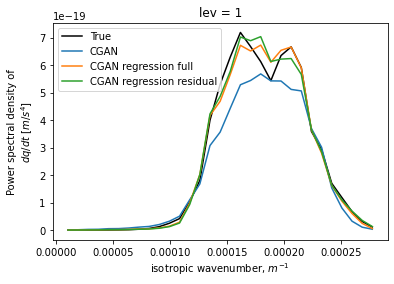

In [10]:
cgan_none.PSD.isel(lev=0).plot(label='True', color='k')
cgan_none.PSD_gen.isel(lev=0).plot(label='CGAN')
cgan_full.PSD_gen.isel(lev=0).plot(label='CGAN regression full')
cgan_residual.PSD_gen.isel(lev=0).plot(label='CGAN regression residual')
plt.legend()

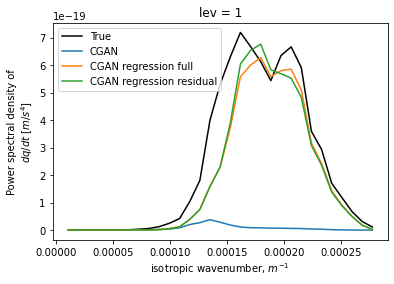

In [11]:
cgan_none.PSD.isel(lev=0).plot(label='True', color='k')
cgan_none.PSD_mean.isel(lev=0).plot(label='CGAN')
cgan_full.PSD_mean.isel(lev=0).plot(label='CGAN regression full')
cgan_residual.PSD_mean.isel(lev=0).plot(label='CGAN regression residual')
plt.legend()

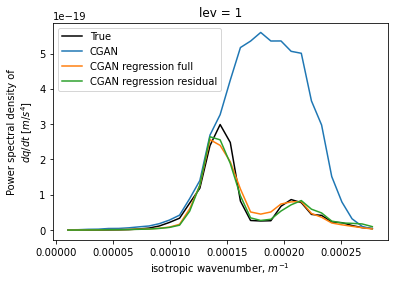

In [12]:
cgan_residual.PSD_res.isel(lev=0).plot(label='True', color='k')
cgan_none.PSD_gen_res.isel(lev=0).plot(label='CGAN')
cgan_full.PSD_gen_res.isel(lev=0).plot(label='CGAN regression full')
cgan_residual.PSD_gen_res.isel(lev=0).plot(label='CGAN regression residual')
plt.legend()

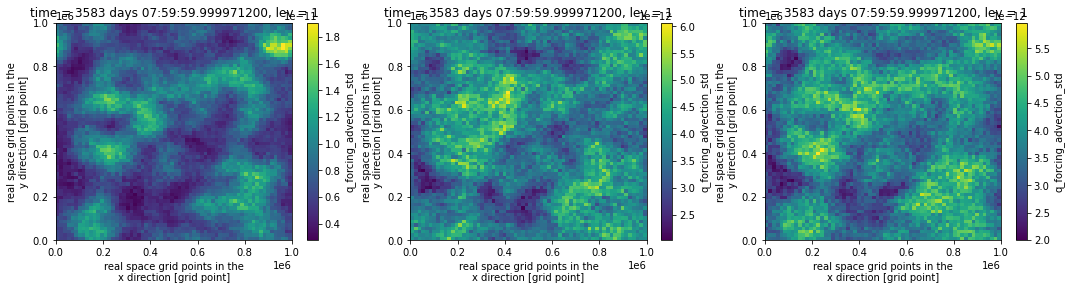

In [15]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
cgan_none.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()
plt.subplot(1,3,2)
cgan_full.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()
plt.subplot(1,3,3)
cgan_residual.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()

In [26]:
%time cgan_residual_1000 = model.test_offline(ds_test.isel(run=slice(0,1)))

M= 1000
CPU times: user 21.5 s, sys: 15.8 s, total: 37.3 s
Wall time: 37.4 s


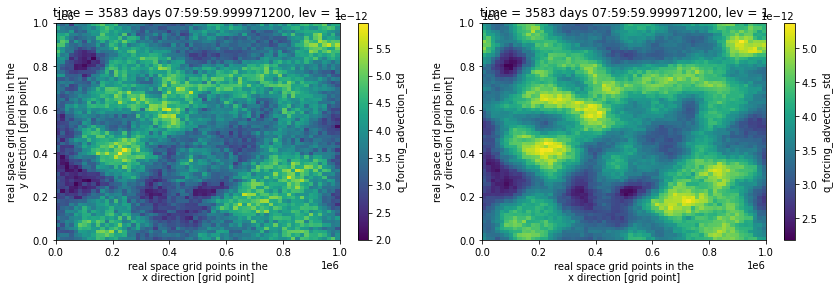

In [25]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
cgan_residual.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()
plt.subplot(1,2,2)
cgan_residual_1000.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()

# Typical runtime
- 16 mins for 20 years run for OLS Model on 1 core. 
- 32 min for GZ model. 
- 16 mins for cGAN without separation

In [98]:
m = stochastic_QGModel({'parameterization': model, 'dt': 14400, 'tmax': 360*86400})
t = time()
m.run()
print('Time for 20 years run in mins=', (time()-t)*20/60)

Time for 20 years run in mins= 11.250957330067953


# Checkup of GAN vs GZ

In [15]:
def reader(path):
    ds = xr.open_dataset(path)
    time = slice(44,None)
    var1 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=0).astype('float64'))**2)
    var2 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=1).astype('float64'))**2)
    ds['CSD_res_ND'] = ds.CSD_res * ds.k / np.sqrt(var1 * var2)
    ds['CSD_gen_res_ND'] = ds.CSD_gen_res * ds.k / np.sqrt(var1 * var2)
    
    time = slice(44,None)
    Nbins = 50
    target = 'q_forcing_advection'
    for lev in [0,1]:
        arr = ds[target].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = float(mean - 4*std); xmax = float(mean + 4*std)
        coords = None
        for suffix in ['', '_gen', '_mean']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, '$dq/dt, s^{-2}$')]
                
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='q_'+str(lev), coords=coords,
                attrs={'long_name': 'subgrid forcing PDF'})
            if np.isnan(ds['PDF'+suffix+str(lev)]).sum() > 0:
                import pdb
                pdb.set_trace()
    return ds

In [16]:
op = 'Operator2-64'
gan = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{op}/CGANRegression/offline_test.nc')
gz = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{op}/MeanVarModel/offline_test.nc')
mse = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{op}/OLSModel/offline_test.nc')

> /state/partition1/job-22987171/ipykernel_2285851/3162848142.py(17)reader()
     15         xmin = float(mean - 4*std); xmax = float(mean + 4*std)
     16         coords = None
---> 17         for suffix in ['', '_gen', '_mean']:
     18             array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
     19             points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)

ipdb> list
     12     for lev in [0,1]:
     13         arr = ds[target].isel(time=time, lev=lev)
     14         mean, std = arr.mean(), arr.std()
     15         xmin = float(mean - 4*std); xmax = float(mean + 4*std)
     16         coords = None
---> 17         for suffix in ['', '_gen', '_mean']:
     18             array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
     19             points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
     20             if coords is None:
     21                 coords=[coord(points, '$dq/dt, s^{-2}$

ipdb> xr.DataArray(density, dims='q_'+str(lev), coords=coords,                 attrs={'long_name': 'subgrid forcing PDF'})
<xarray.DataArray (q_0: 50)>
array([5.35678256e+08, 7.04931646e+08, 8.54293401e+08, 1.08077887e+09,
       1.36973105e+09, 1.67892384e+09, 2.15143742e+09, 2.73178462e+09,
       3.44090398e+09, 4.46514872e+09, 5.70471169e+09, 7.55253994e+09,
       9.69281013e+09, 1.27983481e+10, 1.65390225e+10, 2.15921959e+10,
       2.81100218e+10, 3.62530293e+10, 4.65788820e+10, 5.85173531e+10,
       7.24620876e+10, 8.63150413e+10, 1.00083892e+11, 1.10504317e+11,
       1.16452265e+11, 1.16480183e+11, 1.10102646e+11, 1.00139379e+11,
       8.66430788e+10, 7.19976004e+10, 5.84046338e+10, 4.65541047e+10,
       3.63961095e+10, 2.80618631e+10, 2.17248068e+10, 1.64789986e+10,
       1.25526690e+10, 9.69385706e+09, 7.44610224e+09, 5.79788830e+09,
       4.53110519e+09, 3.45242019e+09, 2.74609264e+09, 2.14096814e+09,
       1.67543408e+09, 1.34565170e+09, 1.05949133e+09, 8.69648348e+

ipdb> arr.q_0
<xarray.DataArray 'q_0' (q_0: 50)>
array([-1.632380e-11, -1.565752e-11, -1.499124e-11, -1.432497e-11,
       -1.365869e-11, -1.299241e-11, -1.232613e-11, -1.165986e-11,
       -1.099358e-11, -1.032730e-11, -9.661023e-12, -8.994746e-12,
       -8.328468e-12, -7.662190e-12, -6.995913e-12, -6.329636e-12,
       -5.663359e-12, -4.997081e-12, -4.330803e-12, -3.664526e-12,
       -2.998249e-12, -2.331971e-12, -1.665694e-12, -9.994163e-13,
       -3.331387e-13,  3.331387e-13,  9.994163e-13,  1.665694e-12,
        2.331971e-12,  2.998249e-12,  3.664526e-12,  4.330803e-12,
        4.997081e-12,  5.663359e-12,  6.329636e-12,  6.995913e-12,
        7.662190e-12,  8.328468e-12,  8.994746e-12,  9.661023e-12,
        1.032730e-11,  1.099358e-11,  1.165986e-11,  1.232613e-11,
        1.299241e-11,  1.365869e-11,  1.432497e-11,  1.499124e-11,
        1.565752e-11,  1.632380e-11], dtype=float32)
Coordinates:
  * q_0      (q_0) float32 -1.632e-11 -1.566e-11 ... 1.566e-11 1.632e-11
Attribut

BdbQuit: 

In [14]:
np.isnan(gan.PDF0).sum()

<xarray.DataArray 'PDF0' ()>
array(50)

-0.09905019361242938


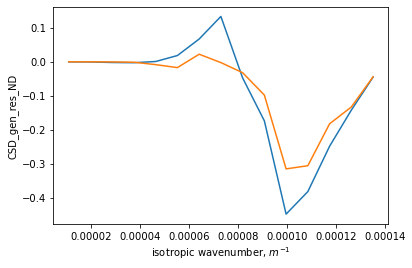

In [334]:
gan.CSD_res_ND.plot()
gan.CSD_gen_res_ND.plot()
print(float(xr.corr(gan.q_forcing_advection_res.isel(lev=0), gan.q_forcing_advection_res.isel(lev=1))))

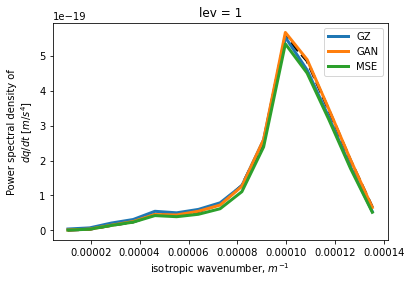

In [310]:
z = 0
gz.PSD.isel(lev=z).plot(lw=3, color='k', ls='--')
gz.PSD_gen.isel(lev=z).plot(lw=3, label='GZ')
gan.PSD_gen.isel(lev=z).plot(lw=3, label='GAN')
mse.PSD_gen.isel(lev=z).plot(lw=3, label='MSE')
plt.legend()

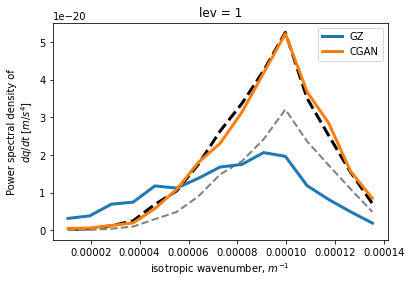

In [311]:
z = 0
gan.PSD_res.isel(lev=z).plot(lw=3, color='k', ls='--')
gz.PSD_res.isel(lev=z).plot(lw=2, color='gray', ls='--')
gz.PSD_gen_res.isel(lev=z).plot(lw=3, label='GZ')
gan.PSD_gen_res.isel(lev=z).plot(lw=3, label='CGAN')
plt.legend()

-0.22605728200380187
-0.2259452778940548


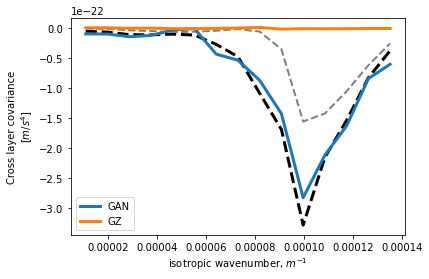

In [312]:
gan.CSD_res.plot(lw=3, color='k', ls='--')
gz.CSD_res.plot(lw=2, color='gray', ls='--')
gan.CSD_gen_res.plot(lw=3, label='GAN')
gz.CSD_gen_res.plot(lw=3, label='GZ')
plt.legend()
print(float(xr.corr(gan.q_forcing_advection_res.isel(lev=0), gan.q_forcing_advection_res.isel(lev=1))))
print(float(xr.corr(gan.q_forcing_advection_gen_res.isel(lev=0), gan.q_forcing_advection_gen_res.isel(lev=1))))

(<matplotlib.image.AxesImage at 0x1465246096a0>,
 <matplotlib.colorbar.Colorbar at 0x1465245b3700>)

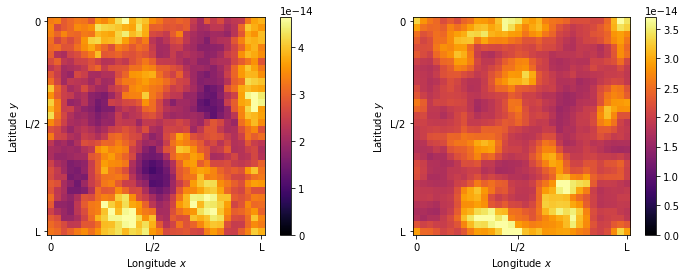

In [313]:
plt.figure(figsize=(12,4))
idx = dict(run=0, time=-1, lev=1)
plt.subplot(1,2,1)
pse.imshow(gan.isel(idx).q_forcing_advection_std)
plt.subplot(1,2,2)
pse.imshow(gz.isel(idx).q_forcing_advection_std)

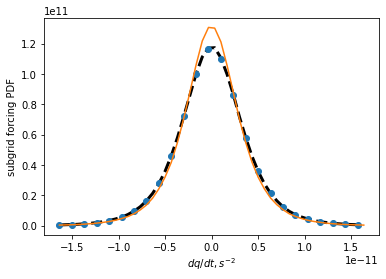

In [399]:
gan.PDF0.plot(color='k', ls='--', lw=3)
gan.PDF_gen0.plot(marker='o', markevery=2, lw=0)
mse.PDF_gen0.plot()
#gz.PDF_gen0.plot(marker='s', markevery=1, lw=30)

In [10]:
gan.PDF_mean0

<xarray.DataArray 'PDF_mean0' (q_0: 50)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * q_0      (q_0) float32 -1.637e-11 -1.57e-11 ... 1.57e-11 1.637e-11
Attributes:
    long_name:  subgrid forcing PDF

In [396]:
gz.q_forcing_advection_gen.std()

<xarray.DataArray 'q_forcing_advection_gen' ()>
array(2.55957386e-12)